In [1]:
import numpy as np
import torch
import torch.nn as nn
import torchvision
from torchvision import models

import cv2
from matplotlib import pyplot as plt

import utils

%matplotlib inline

<B> Load the image, then convert and normalize to torch tensor of appropriate dimensions </B>

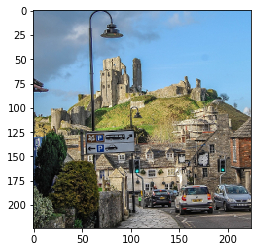

In [2]:
img = np.array(cv2.imread('image/castle.jpg'))[..., ::-1] / 255.0
mean = torch.Tensor([0.485, 0.456, 0.406]).reshape(1,-1,1,1)
std  = torch.Tensor([0.229, 0.224, 0.225]).reshape(1,-1,1,1)
X = (torch.FloatTensor(img[np.newaxis].transpose([0, 3, 1, 2])*1) - mean) / std

plt.imshow(img)

<B> Load pretrained VGG-16 network, check its prediction wrt the image (we will convert the model's dense layers to convolutional layers later on) </B>

In [3]:
model = models.vgg16(pretrained=True)
model.eval()

scores = model(X).detach().numpy().reshape(-1)
ind = np.argsort(-scores)
for i in ind[:10]:
    print('%20s (%3d): %6.3f'%(utils.imgclasses[i][:20],i,scores[i]))

              castle (483): 11.029
church, church build (497):  9.522
           monastery (663):  9.401
 bell cote, bell cot (442):  9.047
cinema, movie theate (498):  8.016
        analog clock (409):  7.108
         street sign (919):  7.102
traffic light, traff (920):  7.058
thatch, thatched roo (853):  6.978
                 alp (970):  6.812


<B> Convert VGG network to simplify LRP process </B>

In [4]:
convs = utils.dense2conv(list(model._modules['classifier']), is_vgg=True)
convs = nn.Sequential(utils.UnFlatten(7,7), *convs)
model.classifier = convs
model.avgpool= torch.nn.AvgPool2d((1,1))

print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

<B> Assure the result of the modified model is the same as original one </B>

In [5]:
scores = model(X).detach().numpy().reshape(-1)
ind = np.argsort(-scores)
for i in ind[:10]:
    print('%20s (%3d): %6.3f'%(utils.imgclasses[i][:20],i,scores[i]))

              castle (483): 11.029
church, church build (497):  9.522
           monastery (663):  9.401
 bell cote, bell cot (442):  9.047
cinema, movie theate (498):  8.016
        analog clock (409):  7.108
         street sign (919):  7.102
traffic light, traff (920):  7.058
thatch, thatched roo (853):  6.978
                 alp (970):  6.812


<B> Iterate layers to get Activations of each layer, check the final prediction is correct again! </B>

In [6]:
layers = list(model._modules['features']) + [model._modules['avgpool']] + list(model._modules['classifier'])

L = len(layers)
A = [X] + [None]*L
for l in range(L): 
    A[l+1] = layers[l].forward(A[l]).detach() # A[0..L] is a list of tensors (for Activations)

scores = A[-1].numpy().reshape(-1)
ind = np.argsort(-scores)
for i in ind[:10]:
    print('%20s (%3d): %6.3f'%(utils.imgclasses[i][:20],i,scores[i]))

              castle (483): 11.029
church, church build (497):  9.522
           monastery (663):  9.401
 bell cote, bell cot (442):  9.047
cinema, movie theate (498):  8.016
        analog clock (409):  7.108
         street sign (919):  7.102
traffic light, traff (920):  7.058
thatch, thatched roo (853):  6.978
                 alp (970):  6.812


<B> Let's warm up with some LRP foundation, we'll implement LRP algorithms and rules as below slides illustrated (excerpted from http://heatmapping.org/tutorial/)  </B> 

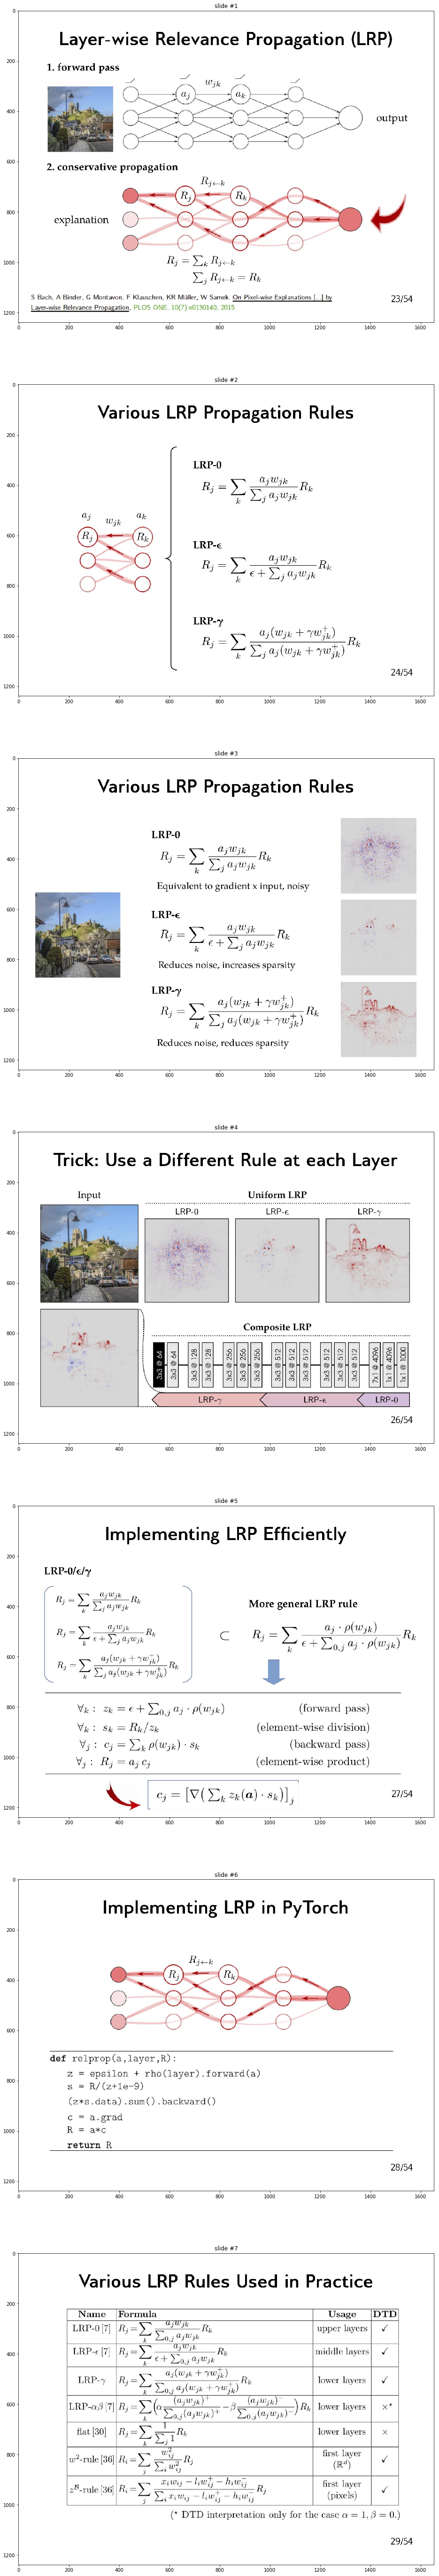

In [7]:
slides = [f'image/LRPTutorial_{i}.jpg' for i in range(1, 8) ]
fig, axs = plt.subplots(len(slides), 1, figsize=(100, 100))
for i, s in enumerate(slides):
    axs[i].set_title(f'slide #{i+1}')
    img = cv2.imread(s)
    content = np.array(img)[..., ::-1]
    axs[i].imshow(content)

In [8]:
target_index = 483 # castle

T = torch.FloatTensor((1.0*(np.arange(1000)==target_index).reshape([1,1000,1,1])))
R = [None]*L + [(A[-1]*T)]  # R[0..L] is a list of tensors (for Relevance) 

for l in range(1, L)[::-1]:
    A[l].requires_grad_()
    if isinstance(layers[l], torch.nn.MaxPool2d): 
        layers[l] = torch.nn.AvgPool2d(2)
    if isinstance(layers[l],torch.nn.Conv2d) or isinstance(layers[l],torch.nn.AvgPool2d):
        if l <= 16:       
            rho = lambda p: p + 0.25*p.clamp(min=0)
            incr = lambda z: z+1e-9
        if 17 <= l <= 30: 
            rho = lambda p: p
            incr = lambda z: z+1e-9 + 0.25*((z**2).mean()**.5).data
        if l >= 31:       
            rho = lambda p: p
            incr = lambda z: z+1e-9

        z = incr(utils.newlayer(layers[l], rho).forward(A[l]))  # step 1
        s = (R[l+1]/z).detach()                                 # step 2
        (z*s).sum().backward(); c = A[l].grad                   # step 3
        R[l] = (A[l]*c).detach()                                # step 4
    else:
        R[l] = R[l+1]

<B> 
As each layer is composed of a collection of two-dimensional feature maps, relevance scores at each layer can be visualized as a two-dimensional map.<br/>
The following diagrams show relevance scores of layers 31, 21, 11, and 1. 
</B>

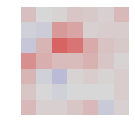

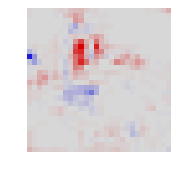

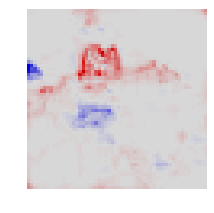

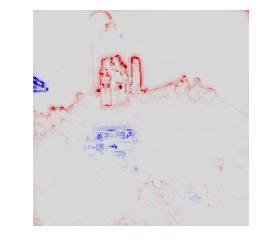

In [9]:
for i,l in enumerate([31, 21, 11, 1]):
    utils.heatmap(R[l][0].numpy().sum(axis=0), 0.5*i+1.5, 0.5*i+1.5)

<B>
As the aforementioned slide #7 illustrated, we have to apply different rule for input layer (pixel layer). The following code implements z^B-rule
</B>

In [10]:
A[0].requires_grad_()

lb = (A[0].detach()*0 + (0-mean)/std).requires_grad_()
hb = (A[0].detach()*0 + (1-mean)/std).requires_grad_()

z = layers[0].forward(A[0]) + 1e-9                                     # step 1 (a)
z -= utils.newlayer(layers[0], lambda p: p.clamp(min=0)).forward(lb)   # step 1 (b)
z -= utils.newlayer(layers[0], lambda p: p.clamp(max=0)).forward(hb)   # step 1 (c)
s = (R[1]/z).detach()                                                  # step 2
(z*s).sum().backward(); c, cp, cm = A[0].grad, lb.grad, hb.grad        # step 3
R[0] = (A[0]*c + lb*cp + hb*cm).detach()                               # step 4

<B>
The relevance scores in the pixel layer are summed over the RGB channels to indicate pixel-wise contributions. <br/>
We observe that the heatmap highlights the outline of the castle as evidence for the corresponding class. <br/>
Some elements such as the traffic sign or the roof on the left are seen as having a negative effect on the neuron "castle" and are consequently highlighted in blue.
</B>

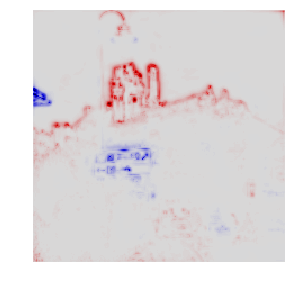

In [11]:
utils.heatmap(np.array(R[0][0]).sum(axis=0), 3.5, 3.5)

<B> Let's lump together related code snippets, and see how LRP explains the pixel-wise contributions of model predictions for some images </B>

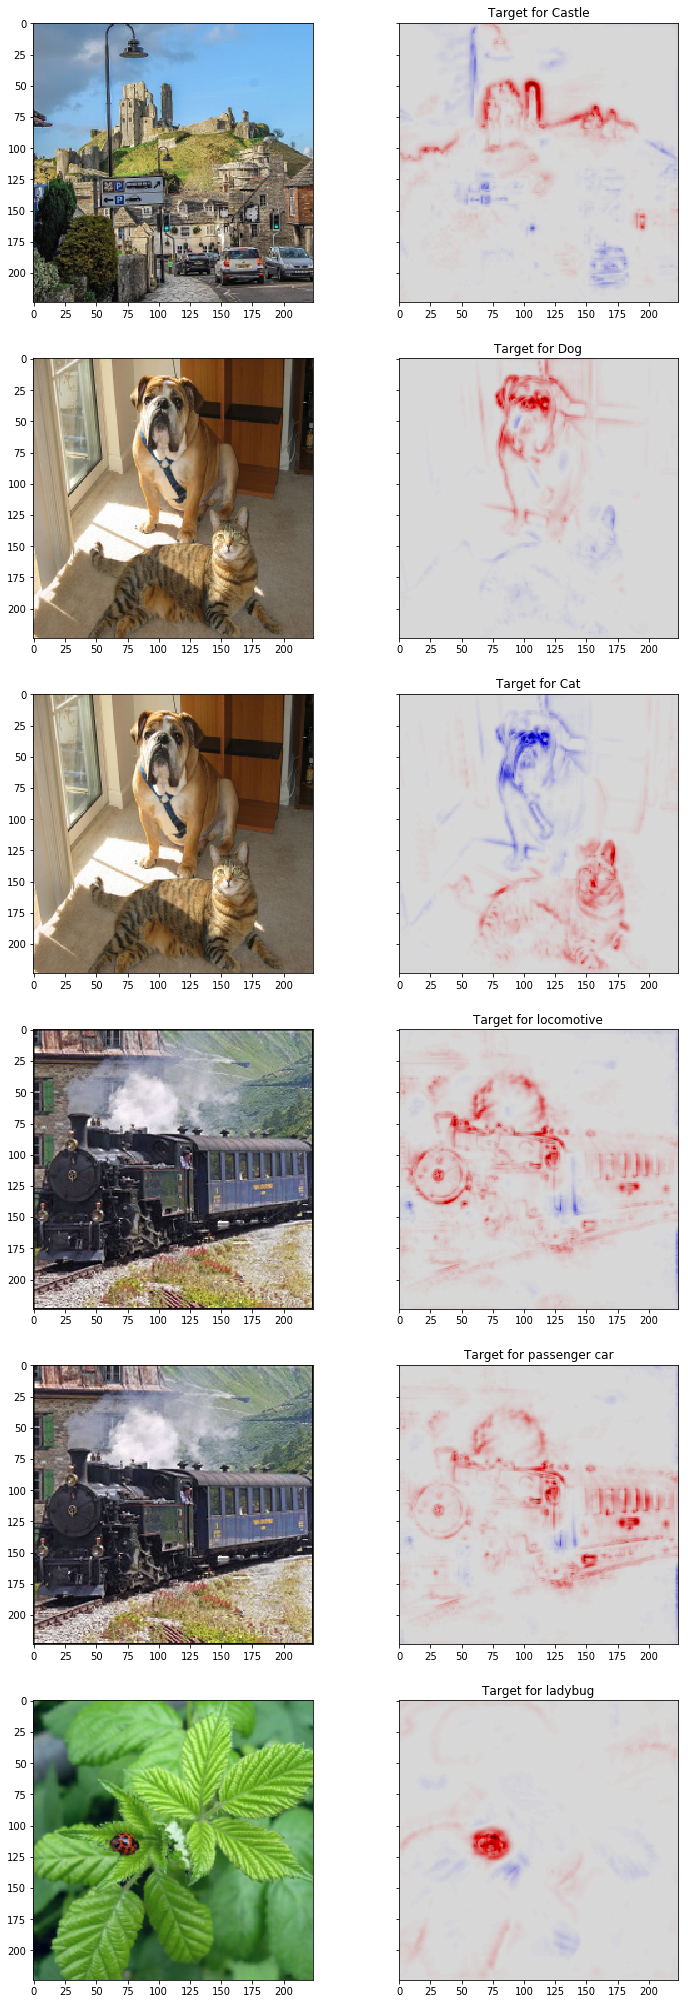

In [12]:
def get_lrp(model_layers, image, target_clsid):
    mean = torch.Tensor([0.485, 0.456, 0.406]).reshape(1,-1,1,1)
    std  = torch.Tensor([0.229, 0.224, 0.225]).reshape(1,-1,1,1)
    X = (torch.FloatTensor(image[np.newaxis].transpose([0, 3, 1, 2])*1) - mean) / std

    L = len(model_layers)
    A = [X] + [None]*L
    for l in range(L): 
        A[l+1] = layers[l].forward(A[l]).detach()  # A[0..L] is a list of tensors (for Activations)

    T = torch.FloatTensor((1.0*(np.arange(1000)==target_clsid).reshape([1,1000,1,1])))
    R = [None]*L + [A[-1]*T]  # R[0..L] is a list of tensors (for Relevance) 

    # layer L to layer 1
    for l in range(1, L)[::-1]:
        A[l].requires_grad_()
        if isinstance(layers[l],torch.nn.MaxPool2d): 
            layers[l] = torch.nn.AvgPool2d(2)
        if isinstance(layers[l],torch.nn.Conv2d) or isinstance(layers[l],torch.nn.AvgPool2d):
            if l <= 16:       
                rho = lambda p: p + 0.25*p.clamp(min=0)
                incr = lambda z: z+1e-9
            if 17 <= l <= 30: 
                rho = lambda p: p
                incr = lambda z: z+1e-9 + 0.25*((z**2).mean()**.5).data
            if l >= 31:       
                rho = lambda p: p
                incr = lambda z: z+1e-9
   
            z = incr(utils.newlayer(layers[l], rho).forward(A[l]))  # step 1
            s = (R[l+1]/z).detach()                                 # step 2
            (z*s).sum().backward(); c = A[l].grad                   # step 3
            R[l] = (A[l]*c).detach()                                # step 4
        else:
            R[l] = R[l+1]

    # layer 0
    A[0].requires_grad_()
    lb = (A[0].detach()*0 + (0-mean)/std).requires_grad_()
    hb = (A[0].detach()*0 + (1-mean)/std).requires_grad_()
    z = layers[0].forward(A[0]) + 1e-9                                     # step 1 (a)
    z -= utils.newlayer(layers[0],lambda p: p.clamp(min=0)).forward(lb)    # step 1 (b)
    z -= utils.newlayer(layers[0],lambda p: p.clamp(max=0)).forward(hb)    # step 1 (c)
    s = (R[1]/z).detach()                                                  # step 2
    (z*s).sum().backward(); c, cp, cm = A[0].grad, lb.grad, hb.grad        # step 3
    R[0] = (A[0]*c + lb*cp + hb*cm).detach()                               # step 4
    return R[0][0].numpy().sum(axis=0)                                     


from matplotlib.colors import ListedColormap
def get_cmap(R):
    b = 10*((np.abs(R)**3.0).mean()**(1.0/3))
    my_cmap = plt.cm.seismic(np.arange(plt.cm.seismic.N))
    my_cmap[:,0:3] *= 0.85
    my_cmap = ListedColormap(my_cmap)
    return my_cmap, b

images = ['image/castle.jpg', 'image/dog_and_cat.png', 'image/dog_and_cat.png', 'image/train.png', 'image/train.png', 'image/bug.png']
target_ids = [483, 243, 282, 820, 705, 301]
titles = ['Target for Castle', 'Target for Dog', 'Target for Cat', 'Target for locomotive', 'Target for passenger car', 'Target for ladybug']
fig, axs = plt.subplots(len(titles), 2, sharey=True, figsize=(12, 36))
relevance = []
for i, (imgpath, target) in enumerate(zip(images, target_ids)):
    image = np.array(cv2.imread(imgpath))[..., ::-1] / 255.0
    relevance = get_lrp(layers, image, target)
    axs[i][0].imshow(image)
    axs[i][1].set_title(titles[i])
    my_cmap, b = get_cmap(relevance)
    axs[i][1].imshow(relevance, cmap=my_cmap,vmin=-b,vmax=b,interpolation='nearest')
